In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

In [ ]:
latent_dim = 2  # Set the dimension of the latent space

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var])

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

In [ ]:
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(decoder_inputs, decoder_outputs)

In [ ]:
vae_outputs = decoder(z)
vae = keras.Model(encoder_inputs, vae_outputs)

In [ ]:
def vae_loss(x, x_decoded_mean):
    z_mean, z_log_var = encoder(x)
    x = tf.keras.backend.flatten(x)
    x_decoded_mean = tf.keras.backend.flatten(x_decoded_mean)
    xent_loss = keras.losses.binary_crossentropy(x, x_decoded_mean)
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss * 0.0001


vae.compile(optimizer="adam", loss=vae_loss)

In [37]:
history = vae.fit(x_train, x_train, epochs=10, batch_size=128, validation_data=(x_test, x_test))

In [ ]:
# Generate new samples by sampling from the learned latent space
z_sample = np.random.normal(size=(1, latent_dim))
x_decoded = decoder.predict(z_sample)


1/1 [==============================] - 0s 157ms/step


4/4 [==============================] - 0s 3ms/step
actual output : 6


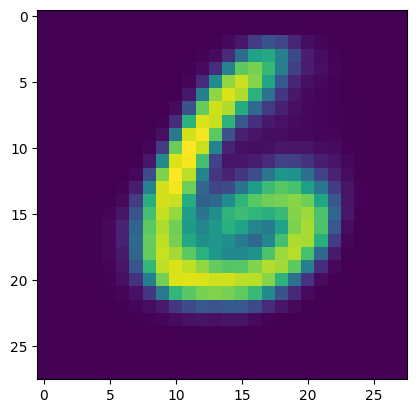

In [ ]:
import matplotlib.pyplot as plt

test = 98

m, l = encoder(x_test[:100])
plt.imshow(decoder.predict(m)[test])

print(f"actual output : {_[test]}")

In [ ]:
vae.save('vae-weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
